In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import load_breast_cancer

# Preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

print("Shape of features:", X.shape)
print("Number of classes:", len(np.unique(y)))
print("Class distribution:", np.bincount(y))

# Convert to DataFrame for easy viewing
df = pd.DataFrame(X, columns=data.feature_names)
df["target"] = y
df.head()


Shape of features: (569, 30)
Number of classes: 2
Class distribution: [212 357]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Original shape: (569, 30)
PCA shape (95% variance): (569, 10)


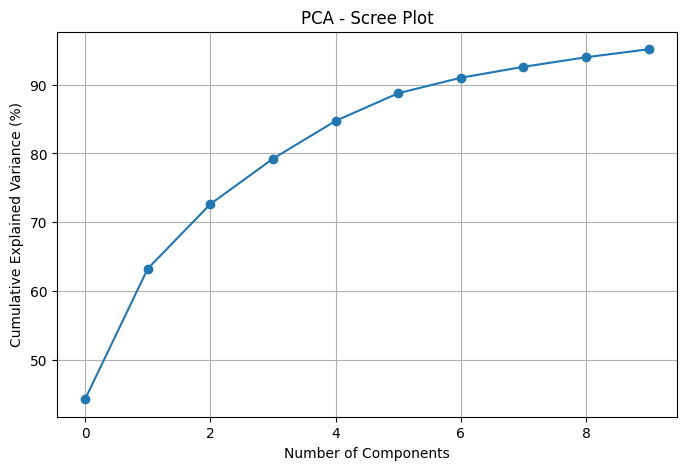

In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X_scaled.shape)
print("PCA shape (95% variance):", X_pca.shape)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA - Scree Plot")
plt.grid(True)
plt.show()


In [4]:
# Dictionary of models & their parameter grids
models = {
    "SVM": (SVC(), {"kernel": ["linear", "rbf"], "C": [0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "NaiveBayes": (GaussianNB(), {"var_smoothing": np.logspace(-9, -6, 4)}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}),
    "LogReg": (LogisticRegression(max_iter=500), {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}),
    "DecisionTree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10, None], "criterion": ["gini", "entropy"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.5, 1.0]}),
    "GradientBoosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss"), {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]})
}

# Define Stacking manually (meta-learner = Logistic Regression)
base_learners = [
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("svm", SVC(probability=True, kernel="rbf", C=1))
]
stacking = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
models["Stacking"] = (stacking, {})


In [5]:
def evaluate_models(X_data, y, models, cv=5):
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, (model, params) in models.items():
        print(f"\n🔹 Training {name}...")
        if params:  # Using GridSearch if params exist
            grid = GridSearchCV(model, params, cv=skf, scoring="accuracy", n_jobs=-1)
            grid.fit(X_data, y)
            best_model = grid.best_estimator_
            scores = cross_val_score(best_model, X_data, y, cv=skf, scoring="accuracy")
        else:  # For Stacking (no param grid her)
            scores = cross_val_score(model, X_data, y, cv=skf, scoring="accuracy")

        results[name] = (scores.mean(), scores.std())
        print(f"{name} - Mean Acc: {scores.mean():.4f}, Std: {scores.std():.4f}")

    return results


In [7]:
import warnings
warnings.filterwarnings("ignore")

print("=== Without PCA ===")
results_no_pca = evaluate_models(X_scaled, y, models)

print("\n=== With PCA ===")
results_pca = evaluate_models(X_pca, y, models)


=== Without PCA ===

🔹 Training SVM...
SVM - Mean Acc: 0.9789, Std: 0.0119

🔹 Training NaiveBayes...
NaiveBayes - Mean Acc: 0.9297, Std: 0.0199

🔹 Training KNN...
KNN - Mean Acc: 0.9683, Std: 0.0154

🔹 Training LogReg...
LogReg - Mean Acc: 0.9737, Std: 0.0166

🔹 Training DecisionTree...
DecisionTree - Mean Acc: 0.9297, Std: 0.0267

🔹 Training RandomForest...
RandomForest - Mean Acc: 0.9543, Std: 0.0210

🔹 Training AdaBoost...
AdaBoost - Mean Acc: 0.9666, Std: 0.0179

🔹 Training GradientBoosting...
GradientBoosting - Mean Acc: 0.9543, Std: 0.0142

🔹 Training XGBoost...
XGBoost - Mean Acc: 0.9613, Std: 0.0142

🔹 Training Stacking...
Stacking - Mean Acc: 0.9701, Std: 0.0180

=== With PCA ===

🔹 Training SVM...
SVM - Mean Acc: 0.9772, Std: 0.0142

🔹 Training NaiveBayes...
NaiveBayes - Mean Acc: 0.9139, Std: 0.0279

🔹 Training KNN...
KNN - Mean Acc: 0.9701, Std: 0.0162

🔹 Training LogReg...
LogReg - Mean Acc: 0.9789, Std: 0.0070

🔹 Training DecisionTree...
DecisionTree - Mean Acc: 0.9456, S

In [8]:
comparison = pd.DataFrame({
    "No-PCA Mean Acc": {k: v[0] for k, v in results_no_pca.items()},
    "No-PCA Std": {k: v[1] for k, v in results_no_pca.items()},
    "PCA Mean Acc": {k: v[0] for k, v in results_pca.items()},
    "PCA Std": {k: v[1] for k, v in results_pca.items()}
})

comparison.sort_values("No-PCA Mean Acc", ascending=False)


,No-PCA Mean Acc,No-PCA Std,PCA Mean Acc,PCA Std
SVM,0.978916,0.011890,0.977162,0.014241
LogReg,0.973669,0.016627,0.978932,0.006990
Stacking,0.970144,0.018041,0.961388,0.021176
KNN,0.968343,0.015357,0.970144,0.016246
AdaBoost,0.966620,0.017873,0.963127,0.011586
XGBoost,0.961341,0.014238,0.963111,0.021749
RandomForest,0.954324,0.021022,0.947291,0.012351
GradientBoosting,0.954277,0.014158,0.961341,0.011881
NaiveBayes,0.929731,0.019922,0.913895,0.027927
DecisionTree,0.929669,0.026711,0.945567,0.020244


=== Without PCA ===


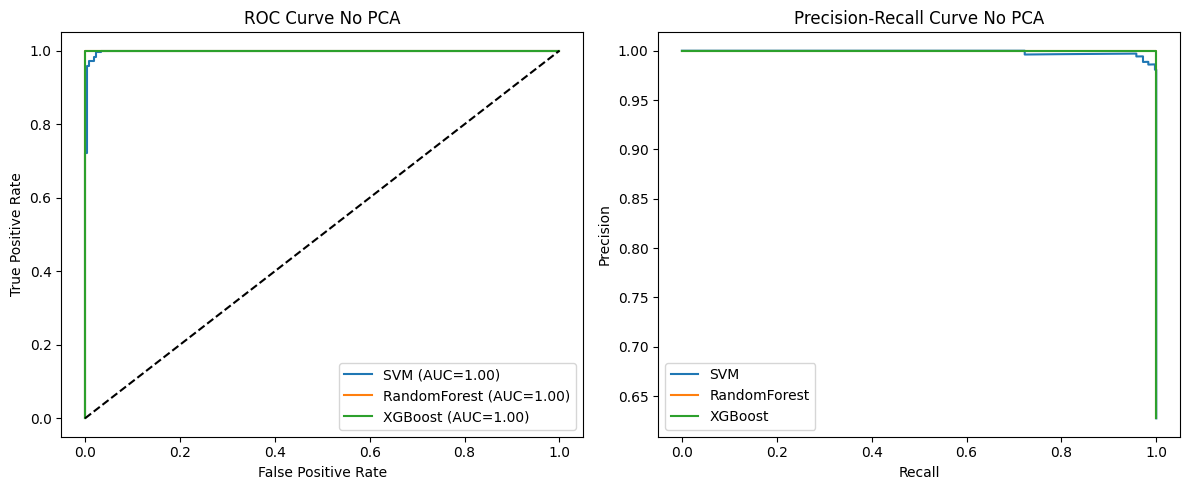

=== With PCA ===


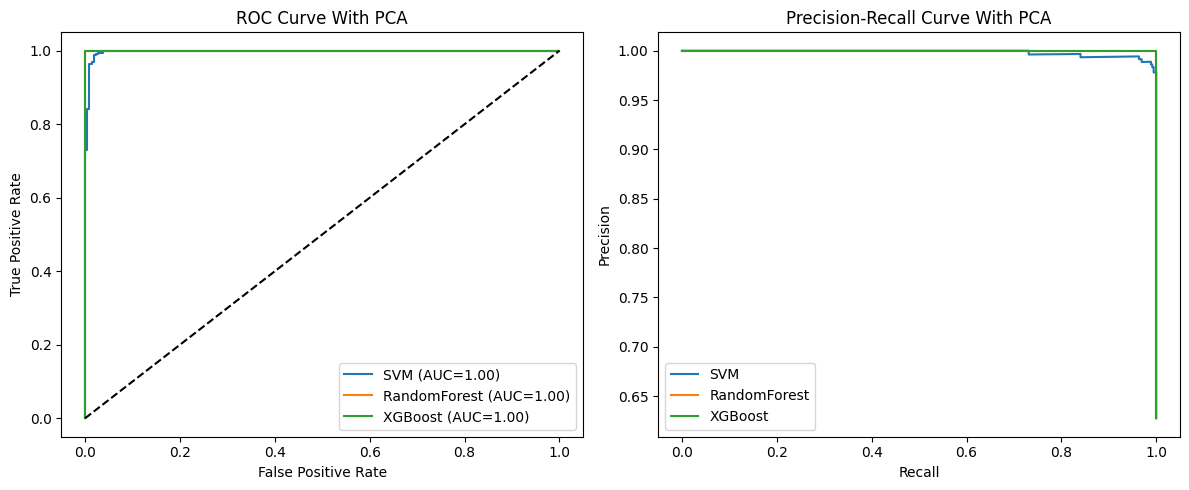

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr(models_to_plot, X_data, y, title_suffix=""):
    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    for name, model in models_to_plot.items():
        model.fit(X_data, y)
        y_score = model.predict_proba(X_data)[:,1]
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"ROC Curve {title_suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # Precision-Recall
    plt.subplot(1,2,2)
    for name, model in models_to_plot.items():
        model.fit(X_data, y)
        y_score = model.predict_proba(X_data)[:,1]
        precision, recall, _ = precision_recall_curve(y, y_score)
        plt.plot(recall, precision, label=name)
    plt.title(f"Precision-Recall Curve {title_suffix}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Select models for visualization
models_to_plot = {
    "SVM": SVC(kernel="rbf", C=1, probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

print("=== Without PCA ===")
plot_roc_pr(models_to_plot, X_scaled, y, "No PCA")

print("=== With PCA ===")
plot_roc_pr(models_to_plot, X_pca, y, "With PCA")




🔹 SVM - Without PCA


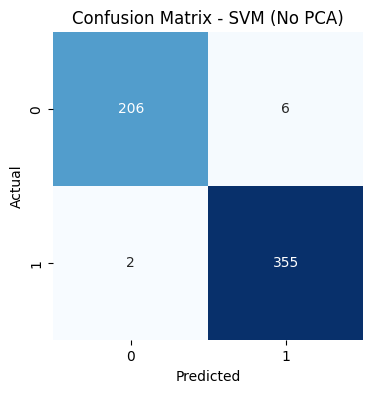

=== Classification Report: SVM (No PCA) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       212
           1       0.98      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.99      0.99      0.99       569


🔹 SVM - With PCA


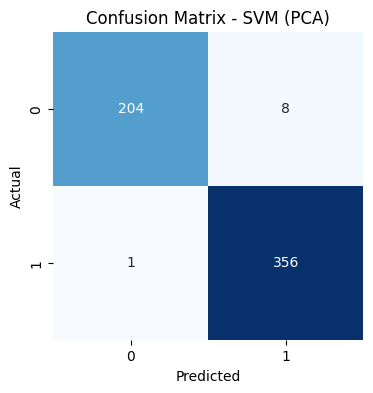

=== Classification Report: SVM (PCA) ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       212
           1       0.98      1.00      0.99       357

    accuracy                           0.98       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



🔹 NaiveBayes - Without PCA


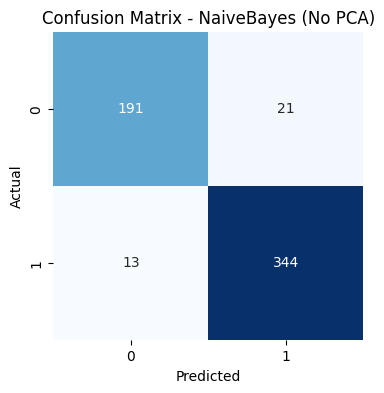

=== Classification Report: NaiveBayes (No PCA) ===
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       212
           1       0.94      0.96      0.95       357

    accuracy                           0.94       569
   macro avg       0.94      0.93      0.94       569
weighted avg       0.94      0.94      0.94       569


🔹 NaiveBayes - With PCA


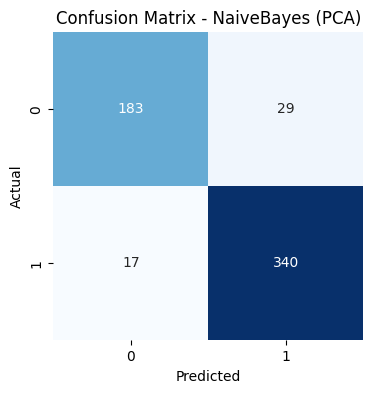

=== Classification Report: NaiveBayes (PCA) ===
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       212
           1       0.92      0.95      0.94       357

    accuracy                           0.92       569
   macro avg       0.92      0.91      0.91       569
weighted avg       0.92      0.92      0.92       569



🔹 KNN - Without PCA


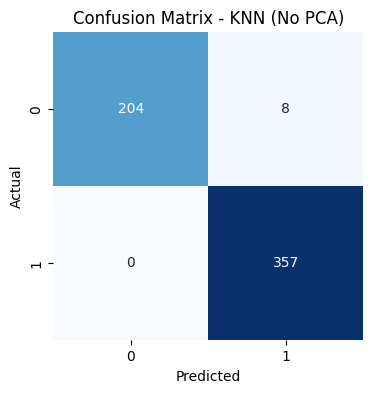

=== Classification Report: KNN (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       212
           1       0.98      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.99      0.99      0.99       569


🔹 KNN - With PCA


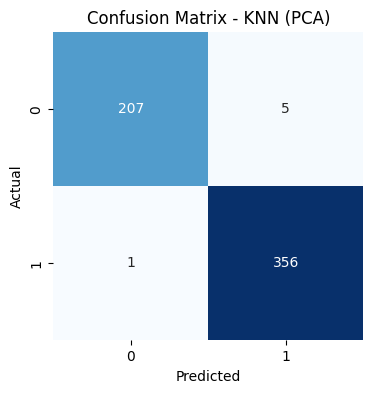

=== Classification Report: KNN (PCA) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       212
           1       0.99      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



🔹 LogReg - Without PCA


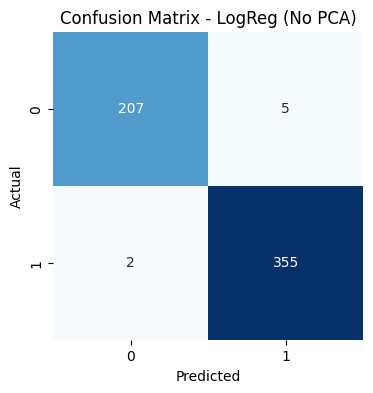

=== Classification Report: LogReg (No PCA) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       212
           1       0.99      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569


🔹 LogReg - With PCA


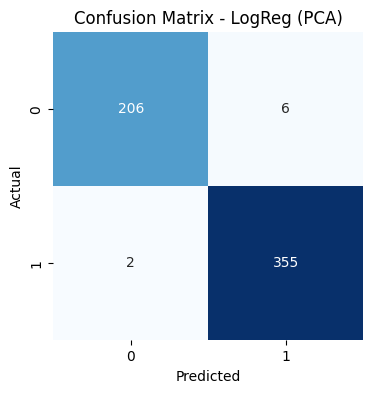

=== Classification Report: LogReg (PCA) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       212
           1       0.98      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.99      0.99      0.99       569



🔹 DecisionTree - Without PCA


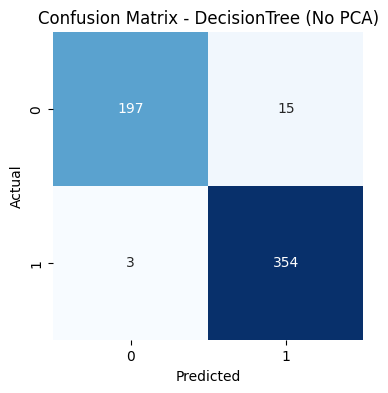

=== Classification Report: DecisionTree (No PCA) ===
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       212
           1       0.96      0.99      0.98       357

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569


🔹 DecisionTree - With PCA


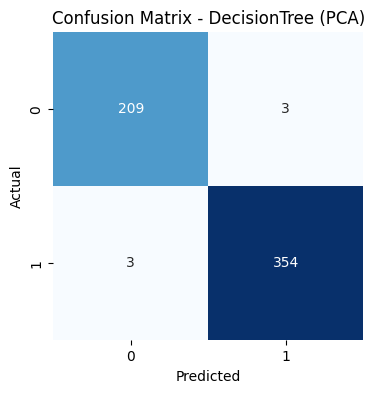

=== Classification Report: DecisionTree (PCA) ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       212
           1       0.99      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



🔹 RandomForest - Without PCA


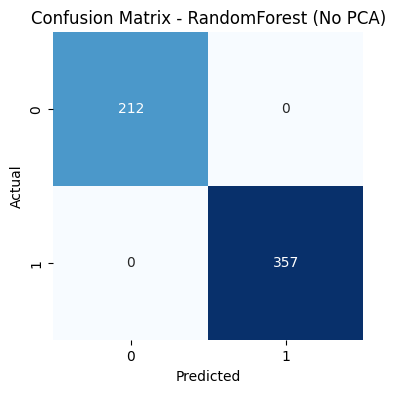

=== Classification Report: RandomForest (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569


🔹 RandomForest - With PCA


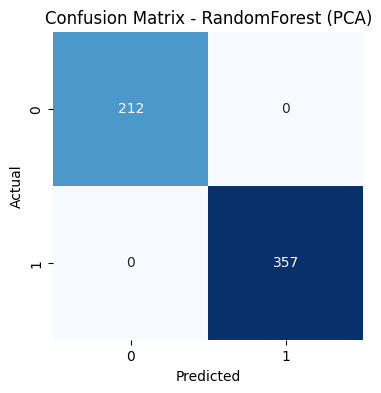

=== Classification Report: RandomForest (PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



🔹 AdaBoost - Without PCA


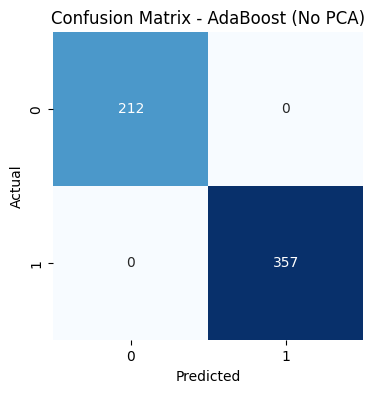

=== Classification Report: AdaBoost (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569


🔹 AdaBoost - With PCA


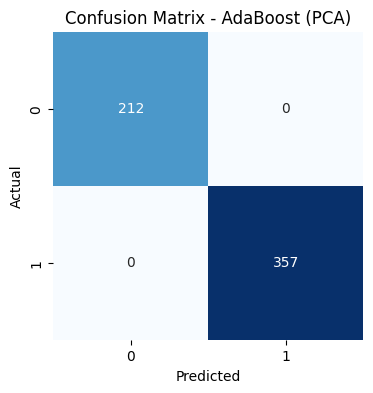

=== Classification Report: AdaBoost (PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



🔹 GradientBoosting - Without PCA


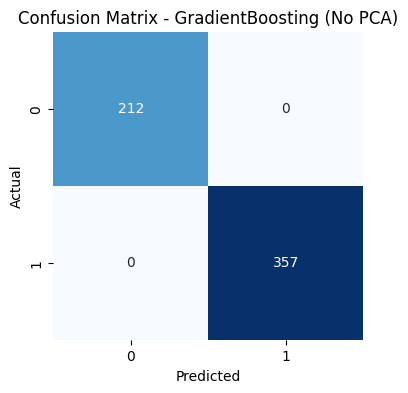

=== Classification Report: GradientBoosting (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569


🔹 GradientBoosting - With PCA


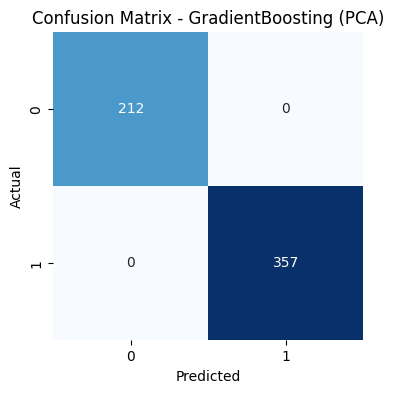

=== Classification Report: GradientBoosting (PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



🔹 XGBoost - Without PCA


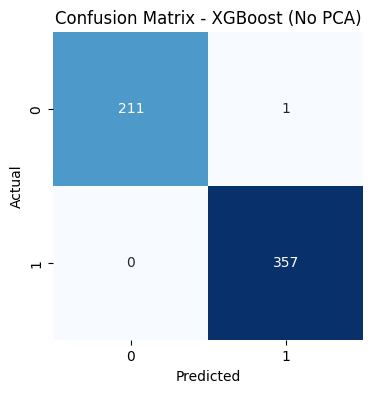

=== Classification Report: XGBoost (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569


🔹 XGBoost - With PCA


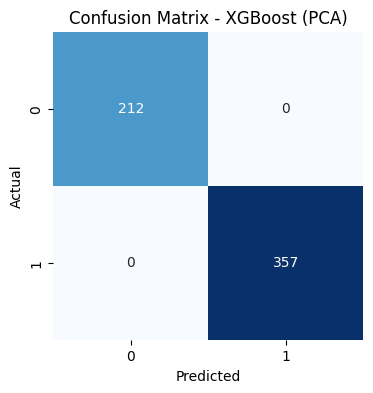

=== Classification Report: XGBoost (PCA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



🔹 Stacking - Without PCA


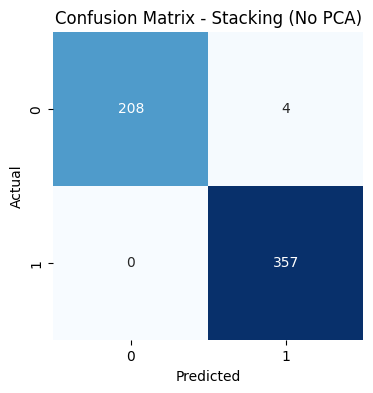

=== Classification Report: Stacking (No PCA) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       212
           1       0.99      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569


🔹 Stacking - With PCA


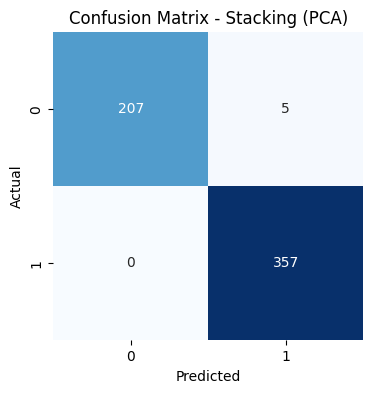

=== Classification Report: Stacking (PCA) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       212
           1       0.99      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



In [13]:
import seaborn as sns

def plot_conf_matrix(model, X_data, y, title=""):
    """Train model, show confusion matrix and classification report."""
    model.fit(X_data, y)
    y_pred = model.predict(X_data)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"=== Classification Report: {title} ===")
    print(classification_report(y, y_pred))


# Run for every model in the dictionary
for model_name, (model, params) in models.items():
    print(f"\n\n🔹 {model_name} - Without PCA")
    if params:  # If hyperparameter grid exists, pick best
        grid = GridSearchCV(model, params, cv=3, scoring="accuracy", n_jobs=-1)
        grid.fit(X_scaled, y)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_scaled, y)
    plot_conf_matrix(best_model, X_scaled, y, f"{model_name} (No PCA)")

    print(f"\n🔹 {model_name} - With PCA")
    if params:
        grid = GridSearchCV(model, params, cv=3, scoring="accuracy", n_jobs=-1)
        grid.fit(X_pca, y)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_pca, y)
    plot_conf_matrix(best_model, X_pca, y, f"{model_name} (PCA)")


In [11]:
def summarize_results(comp_df):
    summary = []
    for model in comp_df.index:
        acc_no = comp_df.loc[model, "No-PCA Mean Acc"]
        acc_pca = comp_df.loc[model, "PCA Mean Acc"]
        if acc_pca > acc_no:
            summary.append(f"{model}: PCA improved performance ({acc_no:.3f} → {acc_pca:.3f}).")
        else:
            summary.append(f"{model}: PCA did not improve ({acc_no:.3f} → {acc_pca:.3f}).")
    return "\n".join(summary)

print("=== PCA Impact Summary ===")
print(summarize_results(comparison))


=== PCA Impact Summary ===
SVM: PCA did not improve (0.979 → 0.977).
NaiveBayes: PCA did not improve (0.930 → 0.914).
KNN: PCA improved performance (0.968 → 0.970).
LogReg: PCA improved performance (0.974 → 0.979).
DecisionTree: PCA improved performance (0.930 → 0.946).
RandomForest: PCA did not improve (0.954 → 0.947).
AdaBoost: PCA did not improve (0.967 → 0.963).
GradientBoosting: PCA improved performance (0.954 → 0.961).
XGBoost: PCA improved performance (0.961 → 0.963).
Stacking: PCA did not improve (0.970 → 0.961).


In [14]:
def crossval_foldwise(X_data, y, models, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    fold_results = {}

    for name, (model, params) in models.items():
        print(f"Running CV for {name}...")
        fold_acc = []

        for train_idx, test_idx in skf.split(X_data, y):
            X_train, X_test = X_data[train_idx], X_data[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            if params:
                grid = GridSearchCV(model, params, cv=3, scoring="accuracy", n_jobs=-1)
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(X_train, y_train)

            y_pred = best_model.predict(X_test)
            fold_acc.append(accuracy_score(y_test, y_pred))

        fold_results[name] = fold_acc
    return pd.DataFrame(fold_results)

# Generate fold-wise tables
print("=== Fold-wise Results (No PCA) ===")
folds_no_pca = crossval_foldwise(X_scaled, y, models)
print(folds_no_pca)

print("\n=== Fold-wise Results (With PCA) ===")
folds_pca = crossval_foldwise(X_pca, y, models)
print(folds_pca)

# Merge fold-wise results
cv_table = pd.concat(
    [folds_no_pca.add_suffix(" (No PCA)"), folds_pca.add_suffix(" (PCA)")],
    axis=1
)

# Compute averages for each model across folds
avg_no_pca = folds_no_pca.mean().add_suffix(" (No PCA)")
avg_pca = folds_pca.mean().add_suffix(" (PCA)")

# Append averages as a new row at the bottom
cv_table.loc["Average"] = pd.concat([avg_no_pca, avg_pca])

cv_table



=== Fold-wise Results (No PCA) ===
Running CV for SVM...
Running CV for NaiveBayes...
Running CV for KNN...
Running CV for LogReg...
Running CV for DecisionTree...
Running CV for RandomForest...
Running CV for AdaBoost...
Running CV for GradientBoosting...
Running CV for XGBoost...
Running CV for Stacking...
        SVM  NaiveBayes       KNN    LogReg  DecisionTree  RandomForest  \
0  0.991228    0.956140  1.000000  0.973684      0.912281      0.973684   
1  0.947368    0.912281  0.956140  0.947368      0.894737      0.938596   
2  0.956140    0.929825  0.947368  0.964912      0.929825      0.947368   
3  0.991228    0.903509  0.982456  0.991228      0.947368      0.947368   
4  0.982301    0.946903  0.955752  0.991150      0.938053      0.964602   

   AdaBoost  GradientBoosting   XGBoost  Stacking  
0  0.982456          0.964912  0.964912  0.991228  
1  0.938596          0.912281  0.938596  0.938596  
2  0.956140          0.956140  0.956140  0.973684  
3  0.973684          0.956140  

,SVM (No PCA),NaiveBayes (No PCA),KNN (No PCA),LogReg (No PCA),DecisionTree (No PCA),RandomForest (No PCA),AdaBoost (No PCA),GradientBoosting (No PCA),XGBoost (No PCA),Stacking (No PCA),SVM (PCA),NaiveBayes (PCA),KNN (PCA),LogReg (PCA),DecisionTree (PCA),RandomForest (PCA),AdaBoost (PCA),GradientBoosting (PCA),XGBoost (PCA),Stacking (PCA)
0,0.991228,0.956140,1.000000,0.973684,0.912281,0.973684,0.982456,0.964912,0.964912,0.991228,0.991228,0.964912,0.973684,0.973684,0.956140,0.982456,0.956140,0.982456,0.982456,0.982456
1,0.947368,0.912281,0.956140,0.947368,0.894737,0.938596,0.938596,0.912281,0.938596,0.938596,0.956140,0.903509,0.947368,0.973684,0.938596,0.938596,0.938596,0.956140,0.947368,0.929825
2,0.956140,0.929825,0.947368,0.964912,0.929825,0.947368,0.956140,0.956140,0.956140,0.973684,0.964912,0.894737,0.956140,0.956140,0.929825,0.947368,0.956140,0.956140,0.938596,0.964912
3,0.991228,0.903509,0.982456,0.991228,0.947368,0.947368,0.973684,0.956140,0.973684,0.964912,0.991228,0.885965,0.964912,0.982456,0.921053,0.938596,0.956140,0.929825,0.938596,0.947368
4,0.982301,0.946903,0.955752,0.991150,0.938053,0.964602,0.964602,0.955752,0.964602,0.982301,0.982301,0.920354,0.955752,0.991150,0.964602,0.955752,0.973451,0.964602,0.973451,0.991150
Average,0.973653,0.929731,0.968343,0.973669,0.924453,0.954324,0.963096,0.949045,0.959587,0.970144,0.977162,0.913895,0.959571,0.975423,0.942043,0.952554,0.956094,0.957833,0.956094,0.963142
